In [14]:
#============== NUMBA AND NUMPY ==============
import sys
import os
import numpy as np
from numpy import linalg as LA
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

from tqdm import tqdm
import matplotlib.gridspec as gridspec
from IPython.display import display, Math
from scipy.linalg import eigh 
from numba import jit
from thomas_solve  import TDMA
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
import database as database
import scipy.sparse.linalg
from tabulate import tabulate



%matplotlib widget




q = 1.602176e-19 #C
kb = 1.3806504e-23 #J/K
nii = 0.0
hbar = 1.054588757e-34
m_e= 9.1093826E-31 #kg
pi=np.pi
eps0= 8.8541878176e-12 #F/m
J2meV=1e3/q
from thomas_solve  import TDMA
#matplotlib options
#plt.rcParams['font.family']         = 'Times New Roman'
#plt.rcParams['font.serif']          = 'Times'
import platform
if platform.system() == 'Linux':
    newpath = os.getcwd() + '/DATA'
    
elif  platform.system() == 'Windows':
    newpath = os.getcwd() + '\\DATA'
    
if not os.path.exists(newpath):
    os.makedirs(newpath)





mpl.rcParams['font.size'] = 13

In [15]:

def H(vpot,mass,dx,n):
    vb   = vpot 
    meff = mass
    H    = np.zeros((n,n))
    m_minus  = (meff[0] + meff[1])/2.0
    m_plus   = (meff[0] + meff[1]) /2.0
    sn_minus =  -pow(hbar/dx,2)/(2.0*m_minus)
    sn_plus  =  -pow(hbar/dx,2)/(2.0*m_plus)
    bi       =  0.5*pow(hbar/dx,2)*((m_plus+m_minus)/(m_plus*m_minus))
    H[0,0]  = bi + vb[0]
    H[0,1]  = sn_plus
    for ii in range (1,n-1):
        m_minus      = (meff[ii] + meff[ii-1])/2.0
        m_plus       = (meff[ii+1]    + meff[ii])/2.0
        sn_minus     = -pow(hbar/dx,2)/(2.0*m_minus)
        sn_plus      = -pow(hbar/dx,2)/(2.0*m_plus)
        bi           =  0.5*pow(hbar/dx,2)*((m_plus+m_minus)/(m_plus*m_minus))
        H[ii,ii-1]  = sn_minus
        H[ii,ii]    = bi + vb[ii] 
        H[ii,ii+1]  = sn_plus
    m_minus     = (meff[n-2] + meff[n-1])/2.0
    m_plus      = (meff[n-1] +  meff[n-2])/2.0
    sn_minus    =  -pow(hbar/dx,2)/(2*m_minus)
    sn_plus     =  -pow(hbar/dx,2)/(2*m_plus)
    bi          =  0.5*pow(hbar/dx,2)*((m_plus+m_minus)/(m_plus*m_minus))
    H[n-1,n-1]  = bi + vb[n-1] 
    H[n-1,n-2]  = sn_minus
    return H

def round2int(x):
    # int(x + (x>0) -0.5) # round2int for positive and negative numbers
        return int(x+0.5)


class sch:
    def __init__(self,structure):
        self.dx       = structure.gridfactor*1e-9 #grid in m
        self.subbands = structure.subbands
        self.material = structure.material 
        totallayer    = np.alen(self.material)
        # Calculate the required number of grid points
        self.x_max    = sum([layer[0] for layer in self.material])*1e-9 #total thickness (m)
        self.n_max    = int(self.x_max/self.dx)
        self.xaxis    = np.arange(0,self.n_max)*self.dx
    

   
        cb_meff           = np.zeros(self.n_max)     #conduction band effective mass to electrons
        CB                = np.zeros(self.n_max) 
        position          = 0.0 # keeping in nanometres (to minimise errors)
        
        for layer in self.material:
                startindex  = round2int(position*1e-9/ self.dx)
                position   += layer[0] # update position to end of the layer
                finishindex = round2int(position*1e-9/self.dx)
                matType     = layer[1]  
                x           = layer[2]
                if matType == 'GaAs':
                    CB[startindex:finishindex] =  0*q #material("GaAs")(T=self.T).band_gap
                    cb_meff[startindex:finishindex]  = 0.0665*m_e
            
                elif matType == 'AlGaAs':
                    CB[startindex:finishindex] =  0.300*q
                    cb_meff[startindex:finishindex]   = 0.096*m_e
                    
        self.CB         = CB
        self.cb_meff    = cb_meff
        
        self.Ee    = np.zeros(self.subbands)
        self.Psie  = np.zeros((self.n_max,self.subbands))
        self.Hamiltonian_e  = H(self.CB,self.cb_meff,self.dx,self.n_max)
        meV = 1e3
            
        # Eigenvalues and Eigenvectors to electrons in Conduction bands
        upper_e       = np.diag(self.Hamiltonian_e,k=1)
        diagonal_e    = np.diag(self.Hamiltonian_e,k=0)
        lower_e       = np.diag(self.Hamiltonian_e,k=-1)
        H_diags_e     = [lower_e,diagonal_e,upper_e]
        Hn_e          = scipy.sparse.diags(H_diags_e, [-1,0,1], format='csc')
        self.energy_e,self.wfe_e = eigsh(Hn_e, k=self.subbands, sigma = 0.0,which = 'LM')
        self.energy_e = self.energy_e.real
        self.wfe_e    = self.wfe_e.real
            
        for i in range(self.subbands):
            self.Psie[:,i]  = np.power(self.wfe_e[:,i],2)
            
        for i in range(self.subbands):
            self.Ee[i]  = self.energy_e[i]/q  # eV
            self.potcb  = self.CB/q
        
        
            
            
                
  
    
        

In [25]:

plt.rcParams['xtick.labelsize']     = 13
plt.rcParams['ytick.labelsize']     = 13
plt.rcParams['axes.linewidth']      = 1
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["xtick.major.size"]    =  7
plt.rcParams["xtick.minor.size"]    =  3.5
plt.rcParams["xtick.major.width"]   =  1
plt.rcParams["xtick.minor.width"]   =  1
plt.rcParams["xtick.direction"]     =  'in'
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["ytick.major.size"]    =  7
plt.rcParams["ytick.minor.size"]    =  3.5
plt.rcParams["ytick.major.width"]   = 1
plt.rcParams["ytick.minor.width"]   =  1
plt.rcParams["ytick.direction"]     =  'in'
plt.rcParams['text.usetex']         =False
plt.rcParams['legend.frameon']      = False






class Structure(object): pass
s = Structure() # this will be our datastructure

# Total subband number to be calculated for electrons
s.subbands = 3
# APPLIED ELECTRIC FIELD

# For 1D, z-axis is choosen
s.gridfactor = 0.05#nm

# REGIONS
# Region input is a two-dimensional list input.
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |
nm = 1E-9

s.material =[
                 [ 4.0, 'AlGaAs',   0.35,   0, 'n','Barrier'],
                 [ 12.0,   'GaAs'  ,      0,   0, 'n','Well'],
                 [ 1.0, 'AlGaAs',   0.35,   0, 'n','Barrier'],
                 [ 4.0,'GaAs'  ,      0,   0, 'n','Well'],
                 [ 8.0, 'AlGaAs',   0.35,   0, 'n','Barrier'],
                ]

sgen = sch(s)

datap = []
datae = []
cbs   = []
xa    = []
for i in range(4,13):
    s.material =[
                 [ 4.0, 'AlGaAs',   0.35,   0, 'n','Barrier'],
                 [ i+4.0,   'GaAs'  ,      0,   0, 'n','Well'],
                 [ 1, 'AlGaAs',   0.35,   0, 'n','Barrier'],
                 [ 4.0,'GaAs'  ,      0,   0, 'n','Well'],
                 [ 4.0, 'AlGaAs',   0.35,   0, 'n','Barrier'],        
                ]
    datap.append((sch(s).Psie))    
    datae.append((sch(s).Ee)) 
    cbs.append((sch(s).potcb)) 
    xa.append((sch(s).xaxis/nm))

In [28]:

def plott(ii):
    index = ii
    cb  = cbs[index] 
    wf1 = 6*datap[index][:,0]+datae[index][0]
    wf2 = 6*datap[index][:,1]+datae[index][1]
    wf3 = 6*datap[index][:,2]+datae[index][2]
    # print(sch(s).Ee)
    idx = np.argwhere(np.diff(np.sign(cb - wf2))).flatten()
    plt.figure(figsize=(10,10))
    plt.plot(xa[index],cb,'-k',lw=2),
    plt.plot(xa[index],wf1,'b'),
    plt.plot(xa[index],wf2,'r'),
    #plt.plot(xa[index],wf3,'g'),
    plt.plot(xa[index][idx[-2::]],wf2[idx[-2::]],'-ko'),
    plt.plot([0,round(max(xa[index]))-2],[datae[index][0],datae[index][0]],'--b'),
    plt.plot([0,round(max(xa[index],))-2],[datae[index][1],datae[index][1]],'--r'),
    plt.xlim(0,30)
    plt.ylim(-0.01,0.32)
    plt.text(4.25+0.9*ii, 0.2, r'$d_{1} =$%d'%(4+ii), fontsize=20)
    plt.yticks(np.arange(0, 0.32, step=0.04))
    #plt.plot([0,round(max(xa[index],))-2],[datae[index][2],datae[index][2]],'--g'),
              
    plt.show()
    


In [29]:
%matplotlib inline
from ipywidgets import interactive, interact
import ipywidgets as widgets

import matplotlib.pyplot as plt

interact(plott, ii=widgets.IntSlider(min=0, max=8, step=1, value=0))


interactive(children=(IntSlider(value=0, description='ii', max=8), Output()), _dom_classes=('widget-interact',…

<function __main__.plott(ii)>

In [9]:
from IPython.display import Image,display
from IPython.core.display import HTML
display(Image(url= "https://cdn.iopscience.com/images/0953-8984/17/28/005/Full/0015801.jpg",width=500, unconfined=True))



In [15]:
import imageio

def plott(ii):
    index = ii
    cb  = cbs[index] 
    wf1 = 6*datap[index][:,0]+datae[index][0]
    wf2 = 6*datap[index][:,1]+datae[index][1]
    wf3 = 6*datap[index][:,2]+datae[index][2]
    # print(sch(s).Ee)
    idx = np.argwhere(np.diff(np.sign(cb - wf2))).flatten()
    fig= plt.figure(figsize=(10,10))
    plt.plot(xa[index],cb,'-k',lw=2),
    plt.plot(xa[index],wf1,'b'),
    plt.plot(xa[index],wf2,'r'),
    #plt.plot(xa[index],wf3,'g'),
    plt.plot(xa[index][idx[-2::]],wf2[idx[-2::]],'-ko'),
    plt.plot([0,round(max(xa[index]))-2],[datae[index][0],datae[index][0]],'--b'),
    plt.plot([0,round(max(xa[index],))-2],[datae[index][1],datae[index][1]],'--r'),
    plt.xlim(0,22)
    plt.ylim(-0.01,0.32)
    plt.text(4.25+0.9*ii, 0.2, r'$d_{1} =$%d'%(4+ii), fontsize=20)
    plt.yticks(np.arange(0, 0.32, step=0.04))
    #plt.plot([0,round(max(xa[index],))-2],[datae[index][2],datae[index][2]],'--g'),
              
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image
    

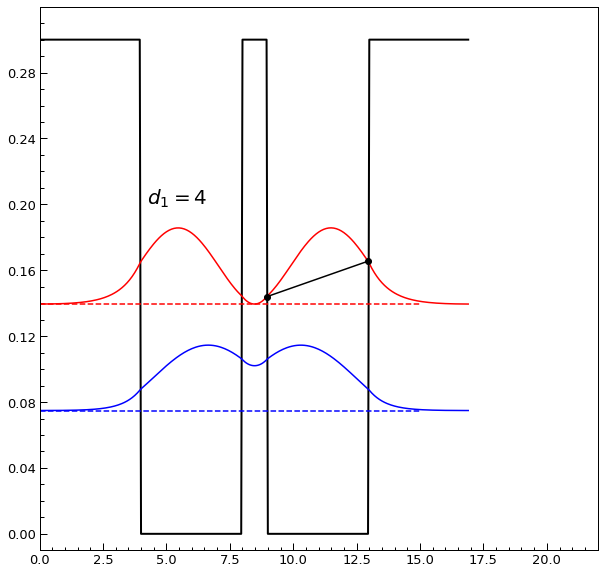

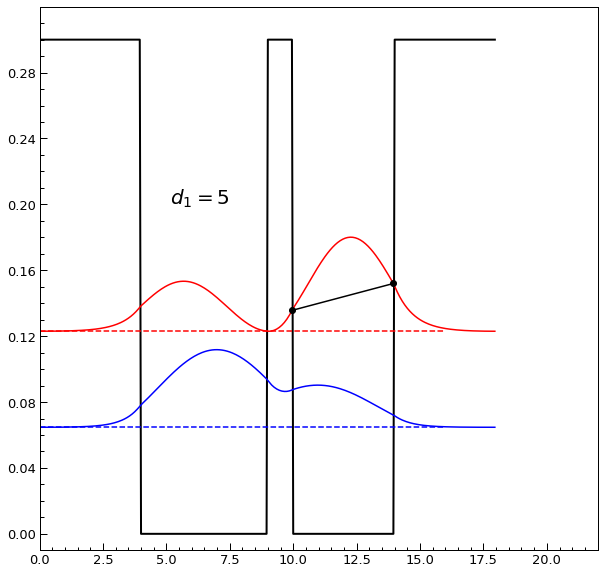

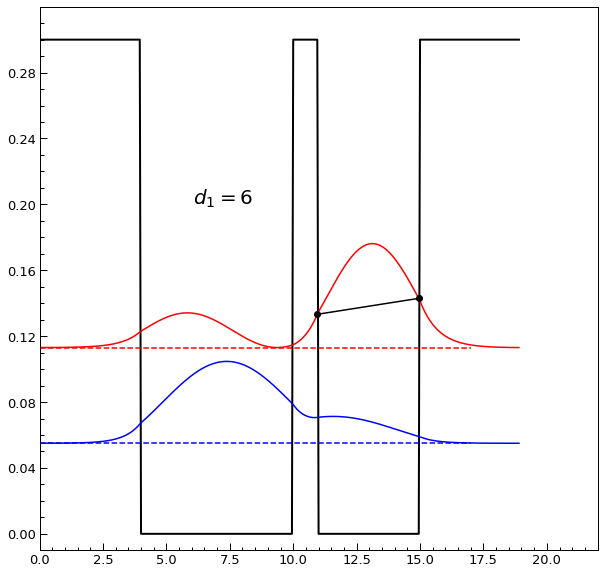

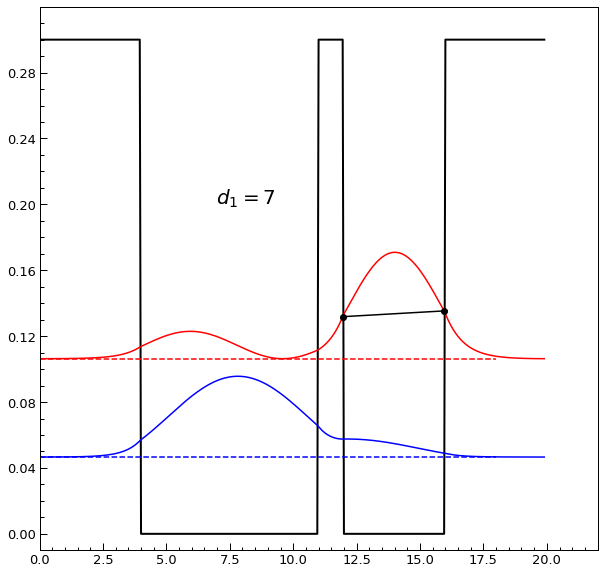

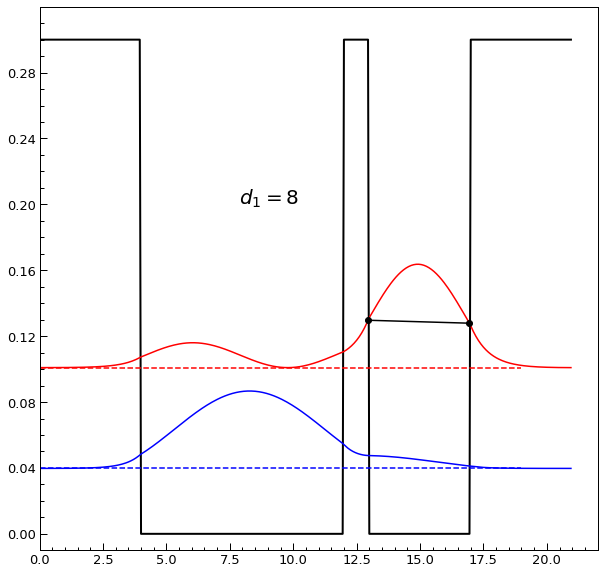

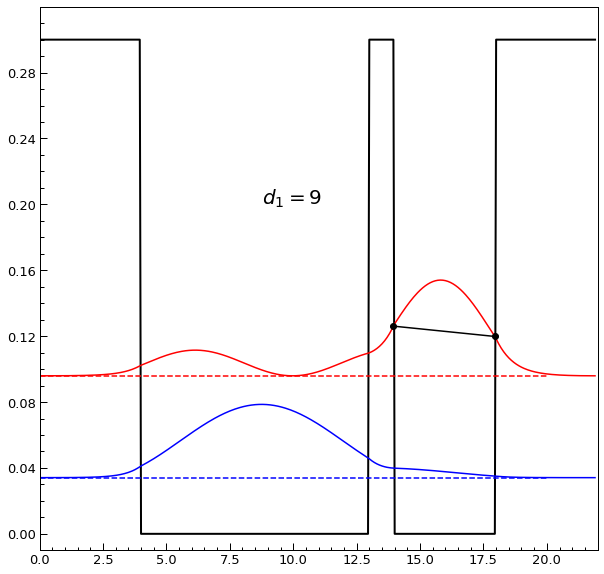

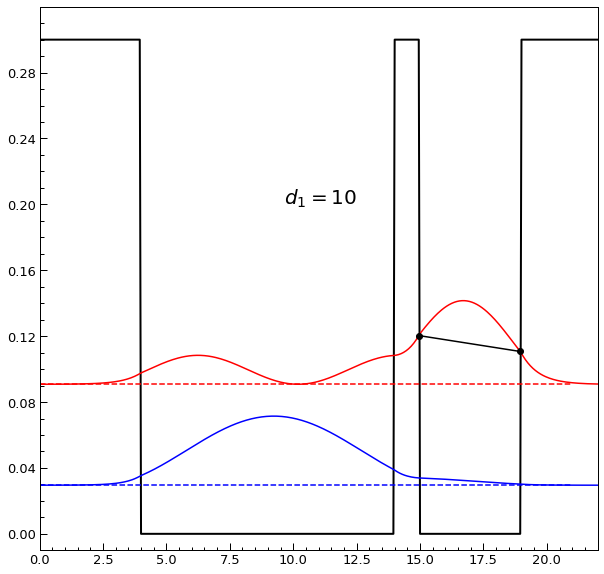

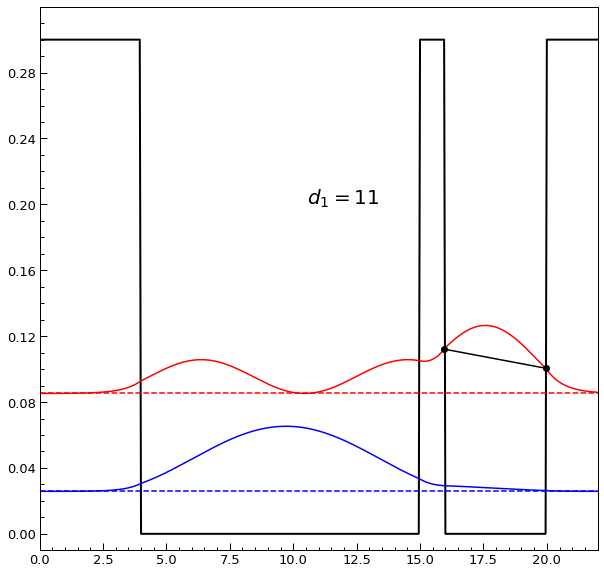

In [25]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./plot.gif', [plott(i) for i in range(8)], fps=2)